In [76]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

ny_df = pd.read_csv('./data/NY/NY/newyork.csv')

In [2]:
ny_df.head()

,Release Year,County of Indictment,Gender,Age at Release,Return Status
0,2008,UNKNOWN,MALE,55,Not Returned
1,2008,ALBANY,MALE,16,Returned Parole Violation
2,2008,ALBANY,MALE,17,Not Returned
3,2008,ALBANY,MALE,17,Returned Parole Violation
4,2008,ALBANY,MALE,18,Not Returned


In [3]:
ny_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188650 entries, 0 to 188649
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Release Year          188650 non-null  int64 
 1   County of Indictment  188650 non-null  object
 2   Gender                188650 non-null  object
 3   Age at Release        188650 non-null  int64 
 4   Return Status         188650 non-null  object
dtypes: int64(2), object(3)
memory usage: 7.2+ MB


In [4]:
ny_df.isnull().sum()

Release Year            0
County of Indictment    0
Gender                  0
Age at Release          0
Return Status           0
dtype: int64

In [5]:
ny_df.describe()

,Release Year,Age at Release
count,188650.000000,188650.000000
mean,2011.326064,35.473400
std,2.289170,10.972873
min,2008.000000,16.000000
25%,2009.000000,26.000000
50%,2011.000000,34.000000
75%,2013.000000,44.000000
max,2015.000000,100.000000


In [6]:
ny_df['Return Status'].value_counts()

Not Returned                 110003
Returned Parole Violation     61381
New Felony Offense            17266
Name: Return Status, dtype: int64

In [7]:
ny_df['Gender'].value_counts(normalize = True)

MALE      0.937228
FEMALE    0.062772
Name: Gender, dtype: float64

In [8]:
#maybe potential here to make this an ordinal target variable like Gabe was interested in however given the categories not sure how insightful it would be.
ny_df['recidivism'] = ny_df['Return Status'].map({'Not Returned': 0, 'Returned Parole Violation' : 1, 'New Felony Offense' : 1})

In [9]:
ny_df['gender_map'] = ny_df['Gender'].map({'MALE': 1, 'FEMALE': 0})
ny_df.head()

,Release Year,County of Indictment,Gender,Age at Release,Return Status,recidivism,gender_map
0,2008,UNKNOWN,MALE,55,Not Returned,0,1
1,2008,ALBANY,MALE,16,Returned Parole Violation,1,1
2,2008,ALBANY,MALE,17,Not Returned,0,1
3,2008,ALBANY,MALE,17,Returned Parole Violation,1,1
4,2008,ALBANY,MALE,18,Not Returned,0,1


In [10]:
ny_df['recidivism'].value_counts()

0    110003
1     78647
Name: recidivism, dtype: int64

In [11]:
#break out male and female into two different datasets and explore variation in relationship between features and target across genders

In [12]:
reinc = ny_df[ny_df['recidivism'] == 1]
reinc.head()

,Release Year,County of Indictment,Gender,Age at Release,Return Status,recidivism,gender_map
1,2008,ALBANY,MALE,16,Returned Parole Violation,1,1
3,2008,ALBANY,MALE,17,Returned Parole Violation,1,1
5,2008,ALBANY,MALE,18,Returned Parole Violation,1,1
6,2008,ALBANY,MALE,18,Returned Parole Violation,1,1
7,2008,ALBANY,MALE,18,Returned Parole Violation,1,1


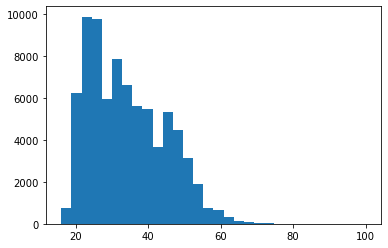

In [13]:
plt.hist(ny_df[ny_df['recidivism'] == 1]['Age at Release'], bins = 30);

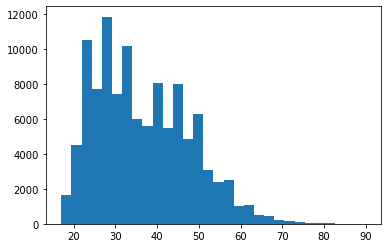

In [14]:
plt.hist(ny_df[ny_df['recidivism'] == 0]['Age at Release'], bins = 30);

In [15]:
#split the dataset into different age ranges below 30, 30-50, 50 and above
below30 = ny_df[ny_df['Age at Release'] < 30]
between_30_50 = ny_df[(ny_df['Age at Release'] >= 30) & (ny_df['Age at Release'] <= 50)]
above50 = ny_df[ny_df['Age at Release'] > 50]

In [16]:
#calculate recidivism rate for each age group
#recidivism = reincarcerated / total pop

below30_recid_rate = (below30[below30['recidivism'] == 1]['recidivism'].value_counts()) / below30.shape[0]
between_30_50_recid_rate = (between_30_50[between_30_50['recidivism'] == 1]['recidivism'].value_counts()) / between_30_50.shape[0]
above_50_recid_rate = (above50[above50['recidivism'] == 1]['recidivism'].value_counts()) / above50.shape[0]

In [17]:
print(f' Recidivism Rate Below 30: {below30_recid_rate}')
print(f' Recidivism Rate Between 30 and 50: {between_30_50_recid_rate}')
print(f' Recidivism Rate Above 50: {above_50_recid_rate}')

 Recidivism Rate Below 30: 1    0.473064
Name: recidivism, dtype: float64
 Recidivism Rate Between 30 and 50: 1    0.400774
Name: recidivism, dtype: float64
 Recidivism Rate Above 50: 1    0.301231
Name: recidivism, dtype: float64


In [18]:
male = ny_df[ny_df['Gender'] == 'MALE']
female = ny_df[ny_df['Gender'] == 'FEMALE']

In [19]:
female.shape

(11842, 7)

In [20]:
male.shape

(176808, 7)

### Modeling

Build and Tune a set of classification models based on gender, age and county of indictment
1. Logistic Regression
2. Random Forest
3. Ada Boost
4. Graident Boost
5. Stacked Model


#### Modeling Without County of Indictment

In [55]:
#Logistic Regression

X = ny_df[['gender_map', 'Age at Release']]
y = ny_df['recidivism']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [56]:
#Baseline 
y_train.value_counts(normalize = True)

0    0.583107
1    0.416893
Name: recidivism, dtype: float64

In [57]:
y_test.value_counts(normalize = True)

0    0.583105
1    0.416895
Name: recidivism, dtype: float64

In [58]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [59]:
log_train = lr.score(X_train, y_train)
log_test = lr.score(X_test, y_test)

In [60]:
#Random Forest
rf= RandomForestClassifier(random_state = 42)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.5870703729618557

In [61]:
rf_train = rf.score(X_train, y_train)
rf_test = rf.score(X_test, y_test)

In [62]:
rf_train

0.5883862121608345

In [63]:
rf_test

0.5870703729618557

In [64]:
#Ada Boost
ada= AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 42))
ada.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=42))

In [65]:
ada_train = ada.score(X_train, y_train)
ada_test = ada.score(X_test, y_test)

In [66]:
ada_test

0.5871127790852999

In [67]:
#Gradient Boost
gboost= GradientBoostingClassifier(random_state = 42)
gboost.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [31]:
gb_train = gboost.score(X_train, y_train)
gb_test = gboost.score(X_test, y_test)

In [68]:
gb_test

0.5870703729618557

In [69]:
#Stacked Model
level1_estimators = [
    ('random_forest', RandomForestClassifier()),
    ('gboost', GradientBoostingClassifier()),
    ('ada', AdaBoostClassifier())
]

stacked_model = StackingClassifier(estimators=level1_estimators,
                                 final_estimator = LogisticRegression())

stacked_model.fit(X_train, y_train)

StackingClassifier(estimators=[('random_forest', RandomForestClassifier()),
                               ('gboost', GradientBoostingClassifier()),
                               ('ada', AdaBoostClassifier())],
                   final_estimator=LogisticRegression())

In [70]:
stack_train = stacked_model.score(X_train, y_train)
stack_test = stacked_model.score(X_test, y_test)

In [77]:
#KNN
ss = StandardScaler()
X_train_sc=ss.fit_transform(X_train)
X_test_sc= ss.transform(X_test)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [78]:
knn_train = knn.score(X_train, y_train)
knn_test = knn.score(X_test, y_test)

#### Rerun Models including County of Indictment

In [34]:
#Get Dummies on County
ny_df.head()

,Release Year,County of Indictment,Gender,Age at Release,Return Status,recidivism,gender_map
0,2008,UNKNOWN,MALE,55,Not Returned,0,1
1,2008,ALBANY,MALE,16,Returned Parole Violation,1,1
2,2008,ALBANY,MALE,17,Not Returned,0,1
3,2008,ALBANY,MALE,17,Returned Parole Violation,1,1
4,2008,ALBANY,MALE,18,Not Returned,0,1


In [35]:
#Creating a Dataframe including dummies of the county of indictment
df_dummies = pd.get_dummies(ny_df['County of Indictment'])
df_dummies['gender'] = ny_df['gender_map']
df_dummies['recidivism'] = ny_df['recidivism']
df_dummies['age'] = ny_df['Age at Release']

In [36]:
df_dummies.head()

,ALBANY,ALLEGANY,BRONX,BROOME,CATTARAUGUS,CAYUGA,CHAUTAUQUA,CHEMUNG,CHENANGO,CLINTON,...,UNKNOWN,WARREN,WASHINGTON,WAYNE,WESTCHESTER,WYOMING,YATES,gender,recidivism,age
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,55
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,16
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,17
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,17
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,18


In [37]:
#Define X and y with dummy data
X = df_dummies.drop(columns = ['recidivism'])
y = df_dummies['recidivism']

#Train test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, random_state =42, stratify = y)

In [38]:
y_train2.value_counts(normalize = True)

0    0.583107
1    0.416893
Name: recidivism, dtype: float64

In [39]:
y_test2.value_counts(normalize = True)

0    0.583105
1    0.416895
Name: recidivism, dtype: float64

In [40]:
#Logistic Regression Model
lr2 = LogisticRegression()
lr2.fit(X_train2, y_train2)

C:\Users\dylan\anaconda3.1\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [41]:
log_train2 = lr2.score(X_train2, y_train2)
log_test2 = lr2.score(X_test2, y_test2)

In [42]:
#Random Forest with Hyperparameter tuning
rf2= RandomForestClassifier(random_state = 42)
rf_params = {
    'n_estimators': [120, 130],
    'max_depth': [15,20],
    'max_features' : [15,20],
    'n_jobs': [-1]
}

gs1 = GridSearchCV(rf, param_grid= rf_params, cv = 3, n_jobs = -1)

gs1.fit(X_train2, y_train2)
print(gs1.best_score_)
gs1.best_params_

KeyboardInterrupt: 

In [ ]:
rf_train2 = gs1.score(X_train2, y_train2)
rf_test2 = gs1.score(X_test2, y_test2)

In [ ]:
#Ada Boost with Hyperparam tuning
ada= AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 42))

ada_params= {
    'n_estimators': [50, 100],
    'base_estimator__max_depth':[1,3]
}

gs2 = GridSearchCV(ada, param_grid = ada_params, cv = 3, n_jobs = -1)
gs2.fit(X_train2, y_train2)
gs2.score(X_train2, y_train2)

In [ ]:
ada_train2 = gs2.score(X_train2, y_train2)
ada_test2 = gs2.score(X_test2, y_test2)

In [ ]:
#Graident Boost
gboost2= GradientBoostingClassifier(random_state = 42)

gboost2.fit(X_train2, y_train2)

In [ ]:
gboost_train2 = gboost2.score(X_train2, y_train2)
gboost_test2 = gboost2.score(X_test2, y_test2)

In [ ]:
#Stacked Model
level1_estimators = [
    ('random_forest', RandomForestClassifier()),
    ('gboost', GradientBoostingClassifier())
]

stacked_model2 = StackingClassifier(estimators=level1_estimators,
                                 final_estimator = LogisticRegression())

stacked_model2.fit(X_train2, y_train2)

In [80]:
#Model Evaluation No Dummies
train_scores = [log_train, rf_train, ada_train, gb_train, stack_train, knn_train]
eval_df = pd.DataFrame(train_scores, columns = ['train_scores'])

eval_df['test_scores'] = [log_test, rf_test, ada_test, gb_test, stack_test, knn_test]
eval_df.index = ['logreg', 'rf', 'ada', 'gb', 'stack', 'knn']
eval_df['diff'] = eval_df['train_scores'] - eval_df['test_scores']
eval_df['baseline'] = .58

eval_df

,train_scores,test_scores,diff,baseline
logreg,0.586831,0.587728,-0.000896,0.58
rf,0.588386,0.587070,0.001316,0.58
ada,0.588386,0.587113,0.001273,0.58
gb,0.588386,0.587070,0.001316,0.58
stack,0.588386,0.587070,0.001316,0.58
knn,0.534304,0.534614,-0.000310,0.58


In [ ]:
#Model Evaluation With Dummies
train_scores2 = [log_train2, rf_train2, ada_train2, gboost_train2]
eval_df2 = pd.DataFrame(train_scores2, columns = ['train_scores'])

eval_df2['test_scores'] = [log_test2, rf_test2, ada_test2, gboost_test2]
eval_df2.index = ['logreg', 'rf', 'ada', 'gb']
eval_df2['diff'] = eval_df2['train_scores'] - eval_df2['test_scores']
eval_df2['baseline'] = .58

eval_df2

### EDA Topics
<br>1) Employment & Recidivism
<br>-Hypothesis: As percent days employed increases, recidivism should decrease
<br>-Is there a pivotal percent of days employed where we see a drop in recidivism?

<br>2) Potential Mitigators
<br>-Recidivism rates between people who did and did not have certain conditions of release

<br>3) Drug Use Deep Dive Looking at the impact of drug use on recidivism rates across THC, Cocaine, Meth
<br>-Some work already performed above but I need a better way to visualize these

<br>4) Gang Affiliation

<br>5)Supervision Risk score 
<br>-How accurate or innacurate is the risk score? 

<br>6) Demographics: Age, Gender, Race, Residence, Education

<br>7) Types of Crime Prior Offense, Years in Prison, Prior Arrest/Conviction Types

In [44]:
#EDA
georgia = pd.read_csv('./data/other/recidivism_full.csv')
georgia.head()

,ID,Gender,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Dependents,...,DrugTests_Meth_Positive,DrugTests_Other_Positive,Percent_Days_Employed,Jobs_Per_Year,Employment_Exempt,Recidivism_Within_3years,Recidivism_Arrest_Year1,Recidivism_Arrest_Year2,Recidivism_Arrest_Year3,Training_Sample
0,1,M,BLACK,43-47,16,False,3.0,Standard,At least some college,3 or more,...,0.000000,0.0,0.488562,0.447610,False,False,False,False,False,1
1,2,M,BLACK,33-37,16,False,6.0,Specialized,Less than HS diploma,1,...,0.000000,0.0,0.425234,2.000000,False,True,False,False,True,1
2,3,M,BLACK,48 or older,24,False,7.0,High,At least some college,3 or more,...,0.166667,0.0,0.000000,0.000000,False,True,False,True,False,1
3,4,M,WHITE,38-42,16,False,7.0,High,Less than HS diploma,1,...,0.000000,0.0,1.000000,0.718996,False,False,False,False,False,1
4,5,M,WHITE,33-37,16,False,4.0,Specialized,Less than HS diploma,3 or more,...,0.058824,0.0,0.203562,0.929389,False,True,True,False,False,1


In [ ]:
georgia.shape

In [ ]:
georgia.isnull().sum().sort_values(ascending = False).head(11)

In [ ]:
georgia['THC'] = georgia['DrugTests_THC_Positive']>0
georgia['Meth'] = georgia['DrugTests_Meth_Positive']>0
georgia['Cocaine'] = georgia['DrugTests_Cocaine_Positive']>0
georgia['Other_Drugs'] = georgia['DrugTests_Other_Positive']>0

georgia['THC'] = georgia['THC'].map({False: 0, True:1})
georgia['Meth'] = georgia['Meth'].map({False: 0, True:1})
georgia['Cocaine'] = georgia['Cocaine'].map({False: 0, True:1})
georgia['Other_Drugs'] = georgia['Other_Drugs'].map({False: 0, True:1})

In [ ]:
georgia.groupby('Meth')['Recidivism_Within_3years'].value_counts(normalize = True)

In [ ]:
georgia.groupby('THC')['Recidivism_Within_3years'].value_counts(normalize = True)

In [ ]:
georgia.groupby('Cocaine')['Recidivism_Within_3years'].value_counts(normalize = True)

In [ ]:
georgia.groupby('Other_Drugs')['Recidivism_Within_3years'].value_counts(normalize = True)

In [ ]:
#It does seem odd to me that these 5k null drug tested folks have a higher recidivism rate. 
#I would have assumed there recidivism rate would have been inline with the folks who had negative drug tests
#Perhaps we shouldn't impute 0 for these folks but rather drop them as they might throw off the model?

georgia[georgia['DrugTests_Meth_Positive'].isnull() == True].groupby('Meth')['Recidivism_Within_3years'].value_counts(normalize = True)

In [ ]:
georgia[georgia['DrugTests_THC_Positive'].isnull() == True].groupby('THC')['Recidivism_Within_3years'].value_counts(normalize = True)

In [ ]:
georgia['target_var'] = georgia['Recidivism_Within_3years'].map({True:1, False:0})
georgia.head()

In [ ]:
georgia.corr()['target_var'].sort_values()

In [ ]:
#Highest Correlated Features (Percent Days Employed, Supervision Risk Score, Condition MH SA, PPViolations, Meth)

georgia.groupby('Percent_Days_Employed')['Recidivism_Within_3years'].value_counts(normalize = True)

In [ ]:
plt.scatter(georgia['target_var'], georgia['Percent_Days_Employed'])

In [ ]:
#How can I show how employment impacts recidivism?
#My hypothesis is that as percent days employed increases, recidivism decreases which we can see with -.24 correlation
#How can I better visualize this?

In [45]:
georgia.columns

Index(['ID', 'Gender', 'Race', 'Age_at_Release', 'Residence_PUMA',
       'Gang_Affiliated', 'Supervision_Risk_Score_First',
       'Supervision_Level_First', 'Education_Level', 'Dependents',
       'Prison_Offense', 'Prison_Years', 'Prior_Arrest_Episodes_Felony',
       'Prior_Arrest_Episodes_Misd', 'Prior_Arrest_Episodes_Violent',
       'Prior_Arrest_Episodes_Property', 'Prior_Arrest_Episodes_Drug',
       'Prior_Arrest_Episodes_PPViolationCharges',
       'Prior_Arrest_Episodes_DVCharges', 'Prior_Arrest_Episodes_GunCharges',
       'Prior_Conviction_Episodes_Felony', 'Prior_Conviction_Episodes_Misd',
       'Prior_Conviction_Episodes_Viol', 'Prior_Conviction_Episodes_Prop',
       'Prior_Conviction_Episodes_Drug',
       'Prior_Conviction_Episodes_PPViolationCharges',
       'Prior_Conviction_Episodes_DomesticViolenceCharges',
       'Prior_Conviction_Episodes_GunCharges', 'Prior_Revocations_Parole',
       'Prior_Revocations_Probation', 'Condition_MH_SA', 'Condition_Cog_Ed',
     